In [1]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import yaml
import pprint
import argparse
import numpy as np
import tensorflow as tf
from src.model_fcn32s import FCN32s
from src.data_loader import dataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def rev_pascal_palette():
    palette = { 0: (  0,   0,   0),
                1: (128,   0,   0),
                2: (  0, 128,   0),
                3: (128, 128,   0),
                4: (  0,   0, 128),
                5: (128,   0, 128),
                6: (  0, 128, 128),
                7: (128, 128, 128),
                8: ( 64,   0,   0),
                9: (192,   0,   0),
                10: ( 64, 128,   0),
                11: (192, 128,   0),
                12: ( 64,   0, 128),
                13: (192,   0, 128),
                14: ( 64, 128, 128),
                15: (192, 128, 128),
                16: (  0,  64,   0),
                17: (128,  64,   0),
                18: (  0, 192,   0),
                19: (128, 192,   0),
                20: (  0,  64, 128)}

    return palette

def convert_from_segmentation_color(arr_2d):
    '''
    Function for converting Labels into RGB
    '''
    arr_3d  = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)
    palette = rev_pascal_palette()
    # slow!
    for i in range(0, arr_2d.shape[0]):
        for j in range(0, arr_2d.shape[1]):
            key = arr_2d[i,j]
            arr_3d[i,j,:] = palette.get(key, 0) # default value if key was not found is 0

    return arr_3d

In [3]:
def show_segmentation(image, label, pred):
    """
    Show image with label
    """
    label = np.argmax(label, axis=-1)
    label_color = convert_from_segmentation_color(arr_2d=label)
    pred  = np.argmax(pred, axis=-1)
    pred_color = convert_from_segmentation_color(arr_2d=pred)
    #---------------------------
    plt.subplot(1, 3, 1)
    plt.title('Input')
    plt.imshow(image[..., ::-1])
    plt.axis('off')
    #---------------------------
    plt.subplot(1, 3, 2)
    plt.title('Ground-Truth')
    plt.imshow(label_color)
    plt.axis('off')
    #---------------------------
    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(pred_color)
    plt.axis('off')    
    
    plt.show()

In [4]:
config_file = './config_files/config_fcn32s_test.yaml'

In [5]:
with open(config_file) as f:
        config = yaml.load(f)

In [6]:
flags = tf.app.flags
flags.DEFINE_string("dataset_name",         config['dataset_name'],          "Dataset Name")
flags.DEFINE_string("exp_dir",              config['exp_dir'],               "Experiment directory")
flags.DEFINE_string("test_dataset_dir",     config['test_dataset_dir'],      "Test Dataset directory")
flags.DEFINE_string("test_name",            config['test_name'],             "Test File")
flags.DEFINE_integer('num_classes',         config['num_classes'],           "Total classes")
flags.DEFINE_string("type2",                config['type2'],                 "Dataset type-- sbd/voc")
flags.DEFINE_string("checkpoint_dir",       config['ckpt_dir'],              "Dir to save the checkpoints")
flags.DEFINE_bool("continue_train",         config['continue_train'],       "Continue Train")
flags.DEFINE_string("init_checkpoint_file", config['init_checkpoint_file'],  "Checkpoint file")
flags.DEFINE_string("mode",                 "Test",                         "Train/Test")
flags.DEFINE_integer("test_batch_size",     config['test_batch_size'],       "The size of of a sample batch")
flags.DEFINE_string("train_model",          config['train_model'],           "Which model to train")
flags.DEFINE_integer("global_step",         config['global_step'],           "Starting Global step")
FLAGS = flags.FLAGS

In [7]:
# Build Model
model = FCN32s(FLAGS)
model.build_test_graph()

In [8]:
opt = FLAGS

In [9]:
# Test Data Loader
test_loader  = dataLoader(opt.test_dataset_dir, opt.test_name, 224, 224,
                          mode='Test', dtype=opt.type2)
test_gen     = test_loader.gen_data_batch(batch_size=opt.test_batch_size)

Dataset Loaded!


### Test

In [10]:
# Set GPU options
config = tf.GPUOptions(allow_growth=True)

# To save model
init_op = tf.group(tf.global_variables_initializer(),\
                   tf.local_variables_initializer())
saver   = tf.train.Saver(max_to_keep=5)

In [11]:
all_img = []
all_lbl = []
all_out = []

In [12]:
# Checkpoint_path
ckpt_dir_path = os.path.join(opt.exp_dir, opt.dataset_name, opt.checkpoint_dir)

In [13]:
with tf.Session(config=tf.ConfigProto(gpu_options=config)) as sess:
    # Intialize the graph
    sess.run(init_op)
    
    # Check if training has to be continued
    if opt.continue_train:
        if opt.init_checkpoint_file is None:
            print('Enter a valid checkpoint file')
        else:
            load_model = os.path.join(ckpt_dir_path, opt.init_checkpoint_file)
            saver.restore(sess, load_model)
            sess.run(tf.assign(model.global_step, opt.global_step))
            print("Resume training from previous checkpoint: %s" % opt.init_checkpoint_file)

    print('Estimating Testing Accuracy....')
    total_steps = test_loader.max_steps//opt.test_batch_size
    for j in range(2):
        val_images, val_labels = next(test_gen)
        feed = {model.images: val_images,
                model.labels: val_labels,
                model.vgg_net.keep_prob: 1.0}
        
        output = sess.run(model.upscore, feed_dict=feed)
        all_out.append(output)
        all_img.append(val_images)
        all_lbl.append(val_labels)

# Close Session
sess.close()

INFO:tensorflow:Restoring parameters from ./experiments/pascal_voc/checkpoint1/fcn32s_bp_16000
Resume training from previous checkpoint: fcn32s_bp_16000
Estimating Testing Accuracy....


In [14]:
print(val_images.shape, val_labels.shape)

(1, 224, 224, 3) (1, 224, 224, 21)


### Plot

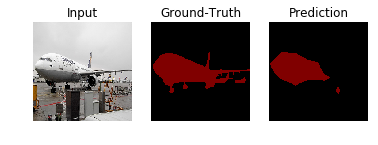

In [15]:
show_segmentation(image=all_img[0][0], label=all_lbl[0][0], pred=all_out[0][0])
